<a href="https://colab.research.google.com/github/oaarnikoivu/dissertation/blob/master/GloVe_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import torch
import random
import re
import nltk
import spacy
import numpy as np

from pathlib import Path
from torchtext import data

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Preprocessing pipeline

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

nlp = spacy.load('en', disable=['parser', 'tagger', 'ner'])

def preprocessor(text):
    text = text.lower()
    text = re.sub(' +', ' ', text)
    text = REPLACE_BY_SPACE_RE.sub('', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    text = text.strip()
  
    return text

def tokenizer(s):
  return [w.text.lower() for w in nlp(preprocessor(s))]

# Load & Generate Data

In [0]:
file_path = '/content/drive/My Drive'

DATA_PATH = Path(file_path + '/datasets/SemEval')
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = tokenizer,
                  lower = True,
                  include_lengths = True,
                  batch_first = True)
LABEL = data.LabelField(sequential = False,
                        use_vocab = False,
                        pad_token = None,
                        unk_token = None, 
                        dtype = torch.float)

dataFields = {"Tweet": ("Tweet", TEXT),
              'anger': ("anger", LABEL),
              'anticipation': ("anticipation", LABEL),
              'disgust': ("disgust", LABEL),
              'fear': ("fear", LABEL),
              'joy': ("joy", LABEL),
              'love': ("love", LABEL),
              'optimism': ("optimism", LABEL),
              'pessimism': ("pessimism", LABEL),
              'sadness': ("sadness", LABEL),
              'surprise': ("surprise", LABEL),
              'trust': ("trust", LABEL)}

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = DATA_PATH,
    train = 'train.csv',
    validation = 'val.csv',
    test = 'test.csv',
    format = 'csv',
    fields = dataFields
)

## List of available pretrained word vectors for PyTorch

- charngram.100d 
- fasttext.en.300d 
- fasttext.simple.300d 
- glove.42B.300d 
- glove.840B.300d 
- glove.twitter.27B.25d 
- glove.twitter.27B.50d 
- glove.twitter.27B.100d 
- glove.twitter.27B.200d 
- glove.6B.50d 
- glove.6B.100d 
- glove.6B.200d 
- glove.6B.300d

In [79]:
MAX_VOCAB_SIZE = 10000

embs = "glove.twitter.27B.100d"

TEXT.build_vocab(train_data,
                 max_size=MAX_VOCAB_SIZE,
                 vectors=embs,
                 unk_init=torch.Tensor.normal_)


.vector_cache/glove.twitter.27B.zip: 0.00B [00:00, ?B/s]
.vector_cache/glove.twitter.27B.zip:   0%|          | 8.19k/1.52G [00:01<70:51:33, 5.96kB/s]
.vector_cache/glove.twitter.27B.zip:   0%|          | 16.4k/1.52G [00:01<52:14:45, 8.08kB/s]
.vector_cache/glove.twitter.27B.zip:   0%|          | 49.2k/1.52G [00:01<37:13:32, 11.3kB/s]
.vector_cache/glove.twitter.27B.zip:   0%|          | 106k/1.52G [00:01<26:25:50, 16.0kB/s] 
.vector_cache/glove.twitter.27B.zip:   0%|          | 221k/1.52G [00:02<18:41:12, 22.6kB/s]
.vector_cache/glove.twitter.27B.zip:   0%|          | 451k/1.52G [00:02<13:10:20, 32.1kB/s]
.vector_cache/glove.twitter.27B.zip:   0%|          | 918k/1.52G [00:02<9:15:49, 45.6kB/s] 
.vector_cache/glove.twitter.27B.zip:   0%|          | 1.84M/1.52G [00:02<6:30:13, 64.9kB/s]
.vector_cache/glove.twitter.27B.zip:   0%|          | 3.69M/1.52G [00:02<4:33:31, 92.4kB/s]
.vector_cache/glove.twitter.27B.zip:   0%|          | 6.56M/1.52G [00:02<3:11:33, 132kB/s] 
.vector_cache/glov

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch = True,
    batch_size = BATCH_SIZE,
    device = device
)

In [81]:
device

device(type='cuda')

In [0]:
LABEL_COLS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

iaux = 0 

for batch in valid_iterator:
  iaux += 1
  aux = batch
  aux2 = torch.stack([getattr(batch, label) for label in LABEL_COLS])
  if iaux == 20: break

In [83]:
torch.transpose(torch.stack([getattr(aux, label) for label in LABEL_COLS]),0,1)

tensor([[0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0.,

# Build the Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class CNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_filters, 
               filter_sizes, output_dim, dropout, pad_idx):
    
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

    self.convs = nn.ModuleList([
                                nn.Conv2d(in_channels = 1,
                                          out_channels = n_filters,
                                          kernel_size = (fs, embedding_dim)) 
                                for fs in filter_sizes])
    
    self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

    self.dropout = nn.Dropout(dropout)
  
  def forward(self, text):
    embedded = self.embedding(text)
    embedded = embedded.unsqueeze(1)
    conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
    pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
    cat = self.dropout(torch.cat(pooled, dim = 1))
    return self.fc(cat)

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [1,1,1]
OUTPUT_DIM = 11
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, 
            FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [92]:
model

CNN(
  (embedding): Embedding(10002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(1, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(1, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(1, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=11, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [93]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,033,811 trainable parameters


In [94]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.5620, -0.7760,  0.8938,  ..., -0.8650,  0.6684, -0.1734],
        [ 0.3180, -0.3438,  0.2044,  ...,  0.0165,  1.0577,  0.6917],
        [-0.0188,  0.0117,  0.0393,  ...,  0.4428,  0.9039, -0.2370],
        ...,
        [-0.5684, -0.6847, -0.3115,  ...,  0.2336,  0.1694, -0.0814],
        [-0.5021,  0.2439,  0.0326,  ...,  0.3676,  0.1151, -0.0780],
        [-0.5216,  0.1387, -0.4253,  ...,  0.6705, -0.2229, -0.6125]])

In [0]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

# Train the Model

In [0]:
import torch.optim as optim

In [0]:
optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
from sklearn.metrics import roc_auc_score

In [0]:
def roc_auc(preds, y):
  global var_y
  global var_preds 
  var_y = y
  var_preds = preds
  acc = roc_auc_score(y, preds)
  return acc

In [0]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.train()

  preds_list = []
  labels_list = []

  for i, batch in enumerate(iterator):
    
    optimizer.zero_grad()

    tweet, tweet_len = batch.Tweet

    predictions = model(tweet).squeeze(1)

    batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
    batch_labels = torch.transpose(batch_labels, 0, 1)

    loss = criterion(predictions, batch_labels)

    loss.backward()

    optimizer.step()

    preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
    labels_list += [batch_labels.cpu().numpy()]

    epoch_loss += loss.item() 
  
  return epoch_loss / len(iterator), roc_auc(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0
  epoch_acc = 0

  model.eval()

  preds_list = []
  labels_list = []
  epoch_acc = []

  with torch.no_grad():
    
    for batch in iterator:

      tweet, tweet_len = batch.Tweet

      predictions = model(tweet).squeeze(1)

      batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
      batch_labels = torch.transpose(batch_labels, 0, 1)

      loss = criterion(predictions, batch_labels)

      epoch_loss += loss.item()

      preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
      labels_list += [batch_labels.cpu().numpy()]

  return epoch_loss / len(iterator), roc_auc(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [103]:
N_EPOCHS = 5

best_valid_loss = float('inf')

train_history = []
valid_history = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'glove-cnn-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.478 | Train Acc: 56.35%
	 Val. Loss: 0.427 |  Val. Acc: 71.56%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.406 | Train Acc: 71.52%
	 Val. Loss: 0.369 |  Val. Acc: 78.52%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.364 | Train Acc: 78.17%
	 Val. Loss: 0.354 |  Val. Acc: 80.40%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.340 | Train Acc: 81.29%
	 Val. Loss: 0.348 |  Val. Acc: 80.81%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.323 | Train Acc: 83.29%
	 Val. Loss: 0.346 |  Val. Acc: 81.56%


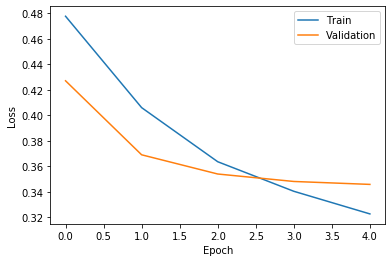

In [104]:
import matplotlib.pyplot as plt

plt.plot(train_history)
plt.plot(valid_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [105]:
model.load_state_dict(torch.load('glove-cnn-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.344 | Test Acc: 80.68%


# Inference

In [0]:
import spacy
nlp = spacy.load('en')

tweet = 'I am quite scared of the future, not gonna lie'
tokenized = [tok.text for tok in nlp.tokenizer(tweet)]
indexed = [TEXT.vocab.stoi[t] for t in tokenized]
tensor = torch.LongTensor(indexed).to(device)
tensor = tensor.unsqueeze(0)

In [107]:
tensor.shape

torch.Size([1, 12])

In [108]:
preds = []

with torch.no_grad():
  model.eval()

  torch.cuda.empty_cache()
  
  tweet = tensor
  predictions = model(tweet)
  preds += [torch.sigmoid(predictions).detach().cpu().numpy()]

  torch.cuda.empty_cache()

preds

[array([[0.15396184, 0.12398289, 0.2715594 , 0.9182622 , 0.04026596,
         0.01144618, 0.0964294 , 0.21663216, 0.48955637, 0.03246303,
         0.02458615]], dtype=float32)]